In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from pytorch_lightning import Trainer

In [2]:
class DataModule(pl.LightningDataModule):
    def __init__(self, n_series=15000, length=1500, noise_std=0.6, val_split=0.2, max_shift=10, batch_size=32, num_workers=4):
        super().__init__()

        self.n_series =n_series
        self.length = length
        self.noise_std = noise_std
        self.val_split = val_split
        self.max_shift = max_shift
        self.batch_size = batch_size
        self.num_workers = num_workers

    def generate_dataset(self):
        t = np.arange(self.length)
        self.data = []
        self.shifts = []
    
        for i in range(self.n_series):
            A = np.random.uniform(0.5, 2.0) #амплитуда
            f = np.random.uniform(0.01, 0.05) #частота
            phi = np.random.uniform(0, 2 * np.pi) #фаза
            shift = np.random.randint(-self.max_shift, self.max_shift + 1) #случайный сдвиг по времени
    
            signal = A * np.sin(2 * np.pi * f * t + phi)
            signal += np.random.normal(0, self.noise_std, self.length)
            signal = np.roll(signal, shift)
    
            self.data.append(signal)
            self.shifts.append(shift)
    
        return np.array(self.data), np.array(self.shifts)

    def setup(self, stage=None):
        X, y = self.generate_dataset()
        X = (X - X.mean(axis=1, keepdims=True)) / (X.std(axis=1, keepdims=True) + 1e-6)
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=self.val_split, random_state=42)

        X_train = torch.tensor(X_train, dtype=torch.float32)
        y_train = torch.tensor(y_train, dtype=torch.float32)

        X_val = torch.tensor(X_val, dtype=torch.float32)
        y_val = torch.tensor(y_val, dtype=torch.float32)

        self.train_dataset = TensorDataset(X_train, y_train)
        self.val_dataset = TensorDataset(X_val, y_val)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

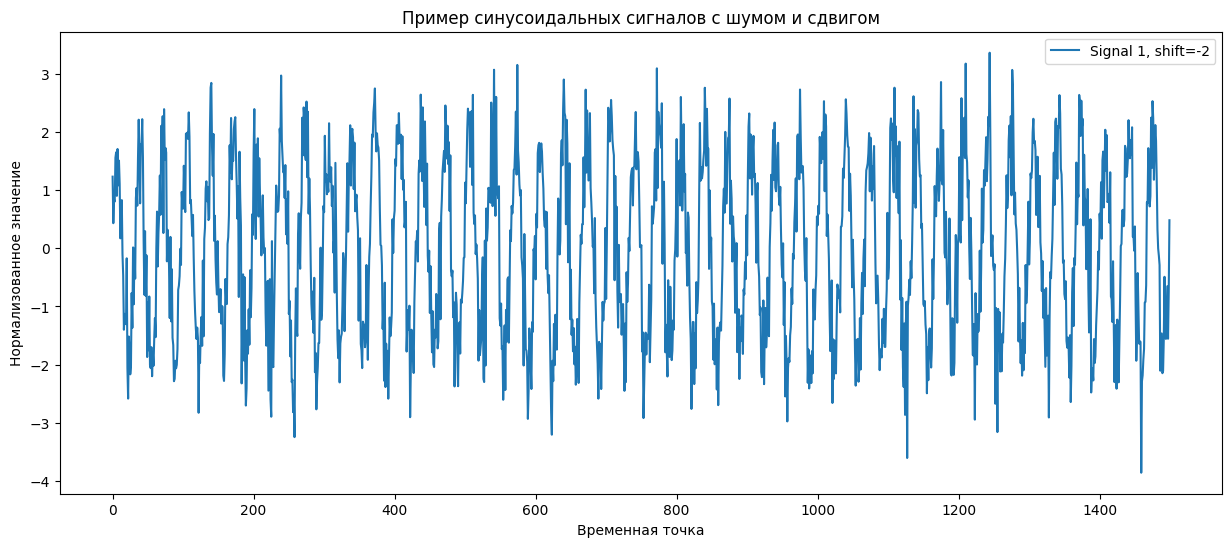

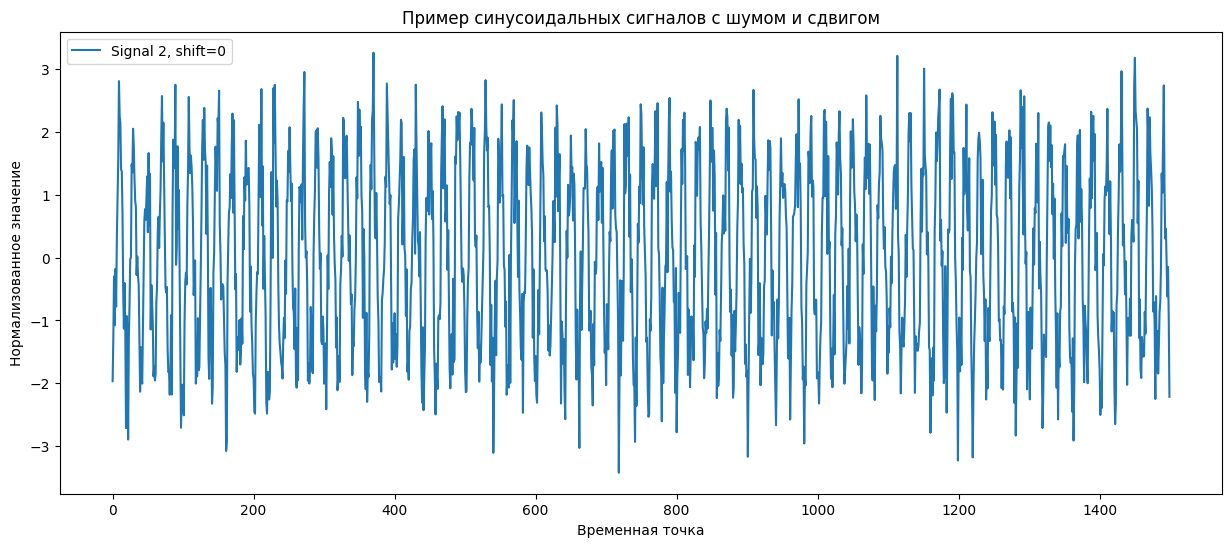

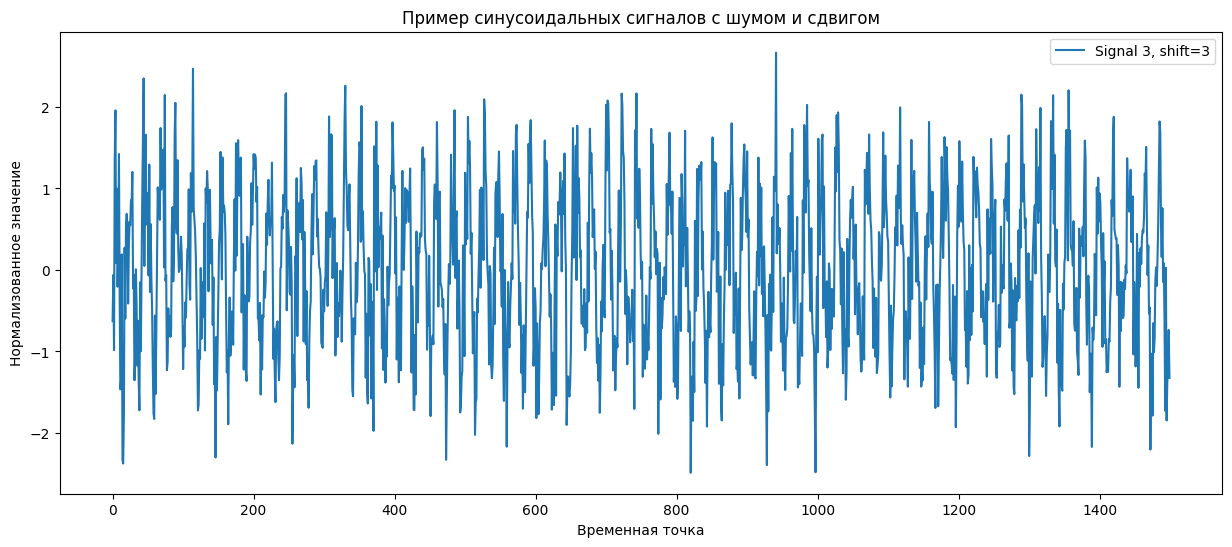

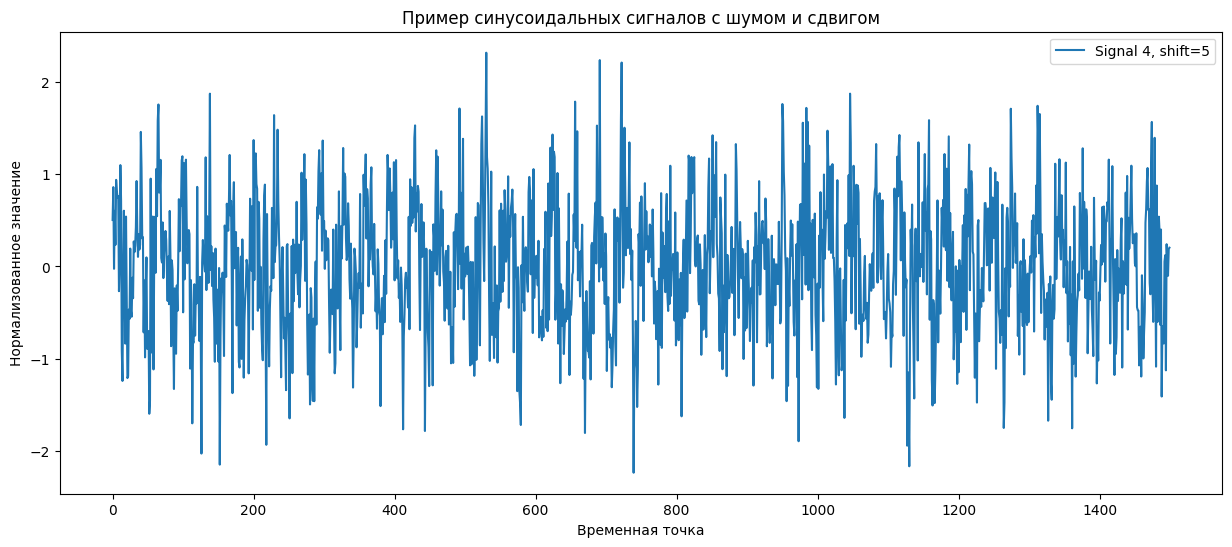

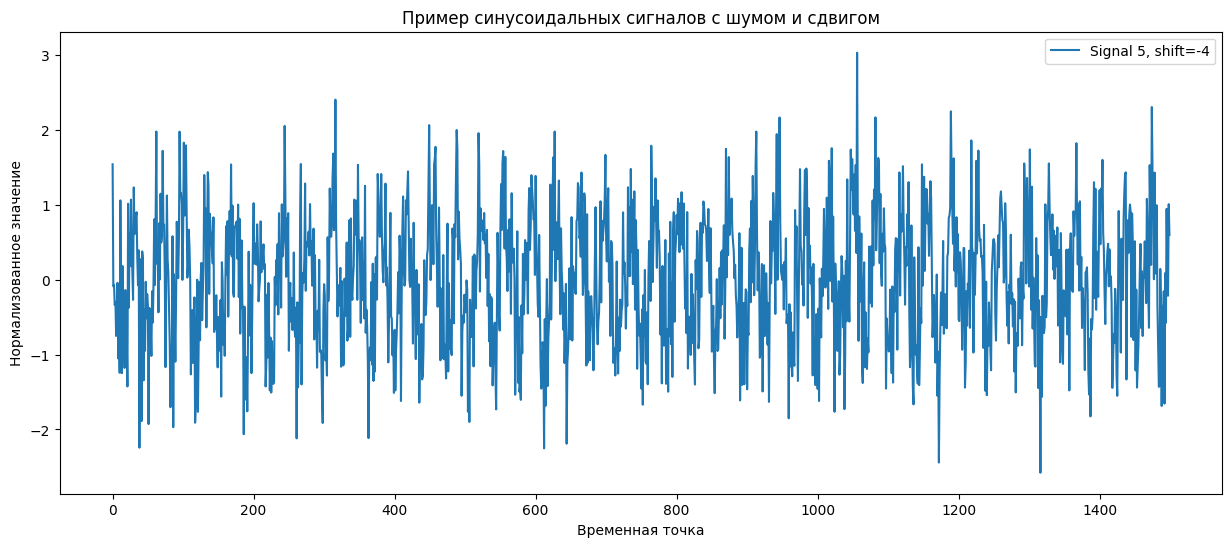

In [3]:
data_module = DataModule()
X, y = data_module.generate_dataset()


for i in range(5):
    plt.figure(figsize=(15, 6))
    plt.plot(X[i], label=f'Signal {i+1}, shift={y[i]}')
    plt.title('Пример синусоидальных сигналов с шумом и сдвигом')
    plt.xlabel('Временная точка')
    plt.ylabel('Нормализованное значение')
    plt.legend()
    plt.show()


In [4]:
X.shape

(15000, 1500)

In [5]:
y.shape

(15000,)

In [6]:
import torch.optim.lr_scheduler as lr_scheduler

class CNNLSTMModel(pl.LightningModule):
    def __init__(self, hidden_size=64, num_layers=2, lr=1e-3):
        super().__init__()
        self.lr = lr
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5, padding=3),
            nn.BatchNorm1d(32),
            nn.ReLU(),

            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )

        self.lstm = nn.LSTM(input_size=64,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            bidirectional=True,
                            dropout=0.3)

        self.fc = nn.Sequential(
            nn.Linear(hidden_size * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )
        
        self.avg_val_losses = []
        self.train_losses = []
        self.val_losses = []

    def forward(self, x):
        x = x.unsqueeze(1)  # (batch, 1, seq_len)

        x = self.conv(x)  # (batch, 64, seq_len//2)
        x = x.permute(0, 2, 1)  # (batch, seq_len//2, 64)

        lstm_out, _ = self.lstm(x)
        last_out = lstm_out[:, -1, :]
        return self.fc(last_out).squeeze()

    def training_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self(X)
        loss = F.mse_loss(y_pred, y)
        self.log("train_loss_mse", loss, prog_bar=True)
        self.train_losses.append(loss.item())
        return loss

    def validation_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self(X)
        loss = F.mse_loss(y_pred, y)
        self.log("val_loss_mse", loss, prog_bar=True)
        self.val_losses.append(loss.item())
        self.avg_val_losses.append(loss.item())
        return loss

    def on_validation_epoch_end(self):
        avg_val_loss = sum(self.avg_val_losses) / len(self.avg_val_losses) if self.avg_val_losses else float('nan')
        print(f"Epoch {self.current_epoch} Val MSE: {avg_val_loss:.4f}")
        self.avg_val_losses.clear()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss_mse',
                'interval': 'epoch',
                'frequency': 1
            }
        }


In [7]:
data = DataModule()
model = CNNLSTMModel()

max_epochs =30
trainer = Trainer(max_epochs=max_epochs, accelerator="auto")
trainer.fit(model, datamodule=data)

2025-06-02 12:10:57.903048: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748866258.110379      18 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748866258.167949      18 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 0 Val MSE: 36.0738


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0 Val MSE: 31.2292


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1 Val MSE: 29.7663


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2 Val MSE: 28.9700


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3 Val MSE: 28.9105


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4 Val MSE: 27.5265


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5 Val MSE: 24.8456


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6 Val MSE: 26.5540


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7 Val MSE: 24.0210


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8 Val MSE: 22.4633


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9 Val MSE: 22.0888


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10 Val MSE: 21.2529


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11 Val MSE: 20.7988


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12 Val MSE: 20.1205


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13 Val MSE: 20.5022


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14 Val MSE: 20.3164


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15 Val MSE: 22.6174


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16 Val MSE: 19.8009


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17 Val MSE: 20.3250


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18 Val MSE: 18.8908


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19 Val MSE: 19.1478


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20 Val MSE: 19.3603


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21 Val MSE: 19.6796


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22 Val MSE: 19.4595


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23 Val MSE: 18.9406


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24 Val MSE: 19.4451


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25 Val MSE: 19.1819


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26 Val MSE: 19.0647


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27 Val MSE: 19.5606


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28 Val MSE: 19.2608


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29 Val MSE: 19.7484


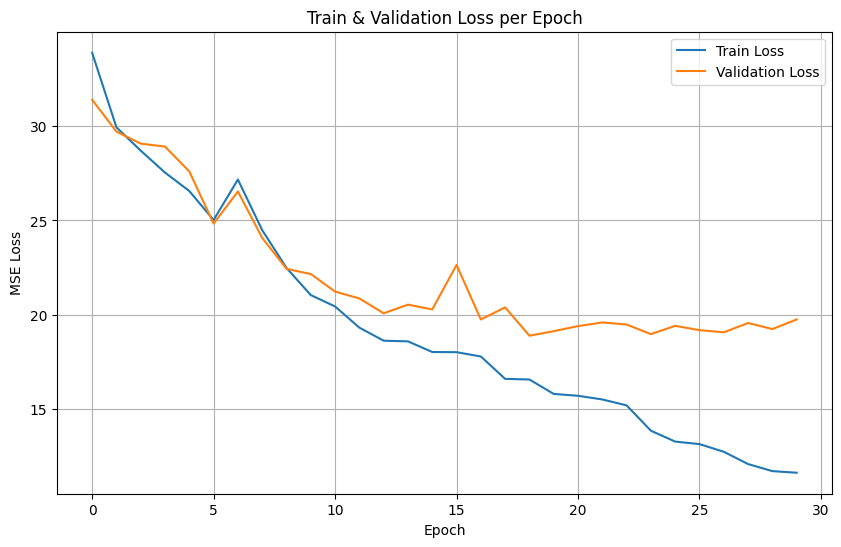

In [8]:
total_train_losses = len(model.train_losses)
total_val_losses = len(model.val_losses)

train_batches_per_epoch = total_train_losses // max_epochs
val_batches_per_epoch = total_val_losses // max_epochs

train_loss_epochs = []
for i in range(max_epochs):
    start = i * train_batches_per_epoch
    end = (i + 1) * train_batches_per_epoch
    epoch_loss = np.mean(model.train_losses[start:end])
    train_loss_epochs.append(epoch_loss)

val_loss_epochs = []
for i in range(max_epochs):
    start = i * val_batches_per_epoch
    end = (i + 1) * val_batches_per_epoch
    epoch_loss = np.mean(model.val_losses[start:end])
    val_loss_epochs.append(epoch_loss)



plt.figure(figsize=(10,6))
plt.plot(train_loss_epochs, label='Train Loss')
plt.plot(val_loss_epochs, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Train & Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()
